In [23]:
import plotly.graph_objects as go
import numpy as np
from scipy.stats import entropy
from Bio import SeqIO
import numpy as np
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import math

This script generates the heatmap shown as part of the results in the main text of the paper. It leverages utility functions from an analysis script provided in the realignment/realign_scripts/stats subfolder to convert all our alignments to vector of gaps and outputs heatmaps of gap placements to show differences in alignment profiles.

wBot4FC_1_PP4_WR.fasta
length of y 150
-----------------------------------------------------
2022-05-30-50p_greedy_only_PP4_WR.fasta
length of y 150
-----------------------------------------------------
post_processing_pasta_PP4_WR.fasta
length of y 150
-----------------------------------------------------
cleaned_aligned_PASTA_9667.fasta
length of y 150
-----------------------------------------------------
mafft-g-ins-i_CORRECT_SEQS.fasta
length of y 150
-----------------------------------------------------
muscle_super5_default_1_CORRECT_SEQS.fasta
length of y 150
-----------------------------------------------------
stats done


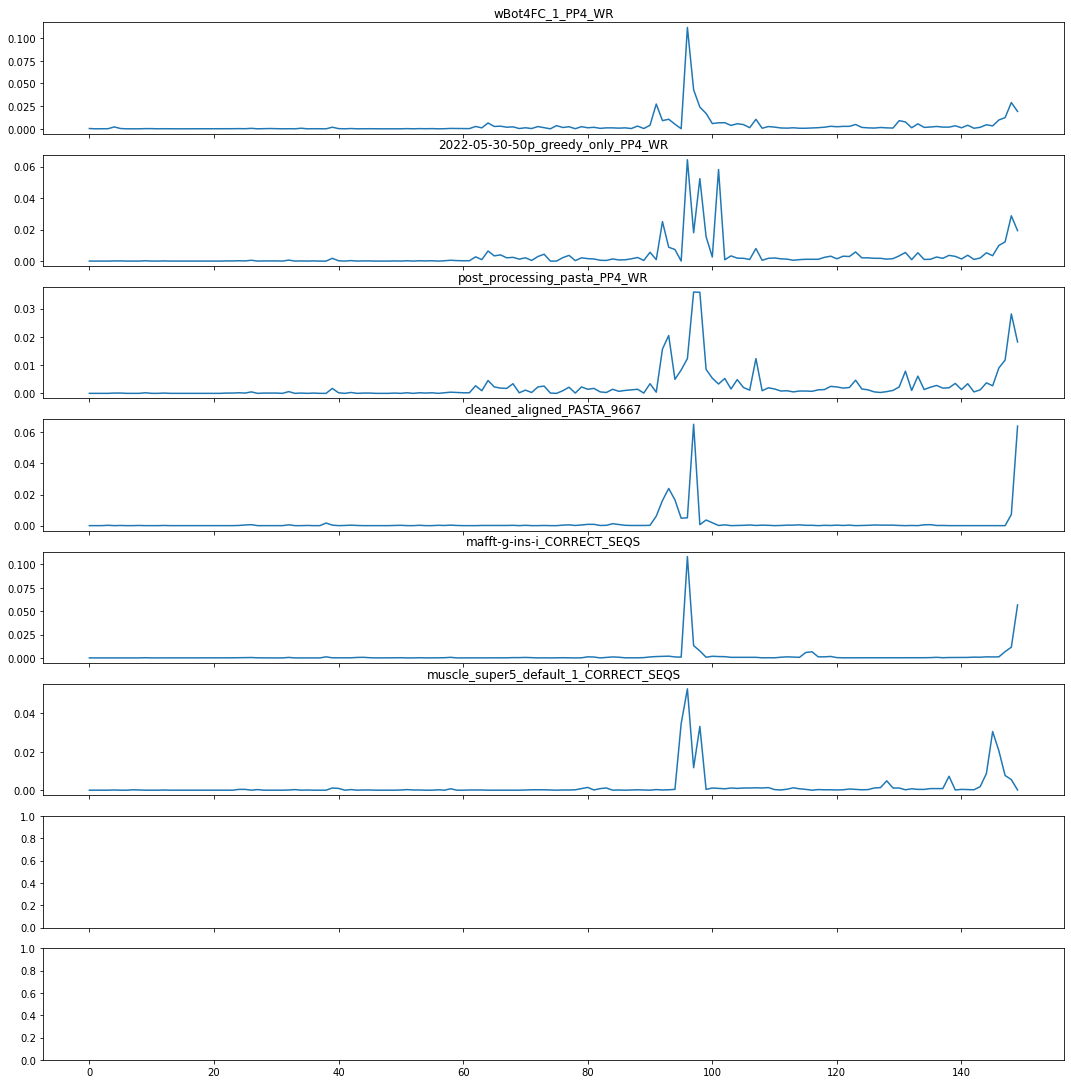

In [13]:
%matplotlib inline


def produce_count_dicts(in_dict, length, start_i=0, end_i=None):
    count_dicts = [{'A': 0, 'C': 0, 'G': 0, 'T': 0, '-': 0} for _ in range(length)]
    if in_dict is not None:
        for k in in_dict:
            if end_i is None:
                end_i = length
            assert end_i == start_i + length
            sliced_seq = in_dict[k][start_i:end_i]
            for i in range(len(sliced_seq)):
                if sliced_seq[i] in count_dicts[i]:
                    count_dicts[i][sliced_seq[i]] += 1
    return count_dicts


def score_count_dicts_nogaps(count_dicts):
    score = 0
    for col_dict in count_dicts:
        for combo in itertools.combinations({'A', 'C', 'G', 'T'}, 2):
            score -= col_dict[combo[0]] * col_dict[combo[1]]
        for nuc in col_dict:
            if nuc == '-':
                continue
            score += col_dict[nuc] * (col_dict[nuc] - 1) / 2
    return score


def score_count_dicts_withgaps(count_dicts):
    score = 0
    for col_dict in count_dicts:
        for combo in itertools.combinations({'A', 'C', 'G', 'T', '-'}, 2):
            score -= col_dict[combo[0]] * col_dict[combo[1]]
        for nuc in col_dict:
            match_score = col_dict[nuc] * (col_dict[nuc] - 1) / 2
            if nuc == '-':
                score -= match_score
            else:
                score += match_score
    return score


def mutual_info(seqs, count_dicts, acc_gap_ratio):
    seq_cnt = len(seqs)
    seqs_list = [seqs[i] for i in seqs.keys()]
    msa_l = len(seqs[list(seqs.keys())[0]])
    P = [{'A': 0, 'C': 0, 'G': 0, 'T': 0, '-': 0} for _ in range(msa_l)]
    for i in range(msa_l):
        for nuc in P[i]:
            P[i][nuc] = (count_dicts[i][nuc] + 1) / seq_cnt  # +1 to solve division by zero
    MI = np.empty([msa_l, msa_l])
    MI[:] = np.nan
    pos_with_acceptable_gaps = [_ for _ in range(len(count_dicts)) if
                                count_dicts[_]['-'] < int(acc_gap_ratio * seq_cnt)]

    nucs = {'A', 'C', 'G', 'T'}
    for ii in range(len(pos_with_acceptable_gaps)):
        i = pos_with_acceptable_gaps[ii]
        for ji in range(ii + 1, len(pos_with_acceptable_gaps)):
            j = pos_with_acceptable_gaps[ji]
            MI[i, j] = 0
            for prod in itertools.product(nucs, nucs):
                P_n1i_n2j = sum([1 if seqs_list[k][i] == prod[0] and seqs_list[k][j] == prod[1] else 0 for k in
                                 range(seq_cnt)]) / seq_cnt
                if P_n1i_n2j == 0:
                    continue
                MI[i, j] += P_n1i_n2j * np.log2(P_n1i_n2j / (P[i][prod[0]] * P[j][prod[1]]))

    print('Mutual Info - without highly gapped columns (more than {agr}%):'.format(agr=acc_gap_ratio * 100),
          np.nanmean(np.where(MI != 0, MI, np.nan)))


def gap_index_measure(sequences, width):
    gap_index_measures = []
    for seq_id in sequences:
        sequence = sequences[seq_id]
        gap_indices = [ind for ind, char in enumerate(sequence) if char == '-']
        num_of_gaps = len(gap_indices)
        min_sum_gap_indices_measure = (num_of_gaps - 1) / (2 * width)
        max_sum_gap_indices_measure = (width - (num_of_gaps + 1) / 2) / width

        _gap_index_measure = (
                                     (sum(gap_indices) / (num_of_gaps * width) - min_sum_gap_indices_measure) /
                                     (max_sum_gap_indices_measure - min_sum_gap_indices_measure)
                             ) * 10
        gap_index_measures.append(_gap_index_measure)

    return gap_index_measures, np.mean(gap_index_measures), np.std(gap_index_measures)



def plot_gap_placement(sequences, cd, title, acc_ratio, GAPS=[]):
    global axs, counter
    cols_to_keep = [_ for _ in range(len(cd)) if cd[_]['-'] <= acc_ratio]
    assert len(cols_to_keep) == 150 
    gap_places = []
    for seq_id in sequences:
        sequence = [sequences[seq_id][_] for _ in cols_to_keep]
        gap_placements = [] 
        for nuc in sequence:
            if nuc == '-':
                gap_placements.append('1')
            else:
                gap_placements.append('0')

        gap_reps = [int(''.join(gap_placements[s]), 2) for s in range(0, len(gap_placements), 1)]
        # if sum(gap_reps) == 0:
        #     continue
        gap_places.append(gap_reps)
    y = np.mean(np.array(gap_places), axis=0)
    x = list(range(len(y)))
    print("length of y",len(y))
    GAPS.append(list(y))
    axs[counter].plot(x, y, '-')
    axs[counter].set_title(title)
    counter += 1
    return GAPS


def plot_gap_placement_perseq(sequences, cd, title, acc_ratio):
    cols_to_keep = [_ for _ in range(len(cd)) if cd[_]['-'] <= acc_ratio]
    assert len(cols_to_keep) == 150
    gap_places = []
    for seq_id in sequences:
        sequence = [sequences[seq_id][_] for _ in cols_to_keep]
        gap_placements = []
        for nuc in sequence:
            if nuc == '-':
                gap_placements.append('1')
            else:
                gap_placements.append('0')

        gap_reps = [np.sqrt(int(''.join(gap_placements[s:s + 20]), 2)) for s in range(0, len(gap_placements), 20)]
        # if sum(gap_reps) == 0:
        #     continue
        gap_places.append(gap_reps)
    plt.figure(figsize=(20, 20))
    for value in range(1):
        y = range(len(sequences))
        x = [gap_places[i][value] for i in range(len(sequences))]
        plt.plot(x, y, '.')

    plt.title(title)
    plt.show()


def gap_heatmap(sequences, cd, acc_ratio, title):
    cols_to_keep = [_ for _ in range(len(cd)) if cd[_]['-'] <= acc_ratio]
    assert len(cols_to_keep) == 150
    gap_reps = []
    for seq_id in sequences:
        sequence = [sequences[seq_id][_] for _ in cols_to_keep]
        gap_rep = []
        for nuc in sequence:
            if nuc == '-':
                gap_rep.append(1)
            else:
                gap_rep.append(0)
        gap_reps.append(gap_rep)
    gap_reps = np.array(gap_reps).transpose()
    df = pd.DataFrame(gap_reps, columns=list(sequences.keys()))

    plt.figure(figsize=(6, 9))
    plt.tight_layout()
    sns.set_theme()
    p1 = sns.heatmap(df.transpose(), cbar=False, yticklabels=False, xticklabels=False)
    p1.invert_yaxis()
    plt.title(title)
    plt.show()

def plot_gaps_per_col(cd, title, algn_h, acc_ratio):
    global axs, counter
    y = [_['-'] * 100 / algn_h for _ in cd if _['-'] <= acc_ratio]
    x = list(range(len(y)))
    axs[counter].plot(x, y, '-')
    axs[counter].set_title(title)
    counter += 1


def stats(alignment_file, acc_gap_ratio=0.8, verbose=1,GAPS=[]):
    seqs = {}
    for record in SeqIO.parse(alignment_file + '.fasta', 'fasta'):
        seqs[record.id] = str(record.seq).upper()

    count_dicts = produce_count_dicts(seqs, len(seqs[list(seqs.keys())[0]]))
    seq_cnt = len(seqs)
    pk = [[cd[v] / (seq_cnt - cd['-']) for v in cd if v != '-'] for cd in count_dicts if cd['-'] != seq_cnt]
    entropies = []
    for c in pk:
        entropies.append(entropy(c, base=2))
    e_a = np.array(entropies)
    n_hgc = sum([1 for _ in count_dicts if _['-'] > int(acc_gap_ratio * seq_cnt)])
    if verbose == 1:
        print(alignment_file + '.fasta')
        GAPS = plot_gap_placement(seqs, count_dicts, alignment_file, int(acc_gap_ratio * seq_cnt),GAPS)
        print('-----------------------------------------------------')
    return score_count_dicts_nogaps(count_dicts), np.mean(e_a), score_count_dicts_withgaps(
        [_ for _ in count_dicts if _['-'] <= int(acc_gap_ratio * seq_cnt)]), score_count_dicts_nogaps(
        [_ for _ in count_dicts if _['-'] <= int(acc_gap_ratio * seq_cnt)]), score_count_dicts_withgaps(count_dicts), GAPS

fig, axs = plt.subplots(8, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout()
counter = 0
GAPS = []

stats('wBot4FC_1_PP4_WR',GAPS=GAPS) #BLS
stats('2022-05-30-50p_greedy_only_PP4_WR',GAPS=GAPS) #Greedy
stats('post_processing_pasta_PP4_WR',GAPS=GAPS) #post processing PASTA
stats('cleaned_aligned_PASTA_9667',GAPS=GAPS) #PASTA
stats('mafft-g-ins-i_CORRECT_SEQS',GAPS=GAPS) #MAFFT
stats('muscle_super5_default_1_CORRECT_SEQS',GAPS=GAPS) # MUSCLE

print("stats done")
plt.show()




In [4]:
LABELS = ["     MUSCLE ", "     MAFFT ", "     PASTA ","     Post-proc. PASTA ","     Greedy Player ","     Borderlands Science "]
LABELS.reverse()


In [6]:
import plotly.graph_objects as go
import numpy as np

In [15]:
print(GAPS[0]) #in the GAPS vector, we have the gap frequency at each column (each index is a column) for each alignment

[0.00031033412640943414, 0.0, 0.00010344470880314473, 0.00010344470880314473, 0.0020688941760628942, 0.00031033412640943414, 0.0, 0.0, 0.0, 0.00020688941760628945, 0.00020688941760628945, 0.0, 0.00010344470880314473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010344470880314473, 0.00010344470880314473, 0.00020688941760628945, 0.00010344470880314473, 0.0005172235440157236, 0.0, 0.00010344470880314473, 0.00031033412640943414, 0.00010344470880314473, 0.0, 0.00010344470880314473, 0.0, 0.0006206682528188683, 0.0, 0.00010344470880314473, 0.0, 0.0, 0.0017585600496534603, 0.00020688941760628945, 0.0, 0.00031033412640943414, 0.0, 0.00010344470880314473, 0.00010344470880314473, 0.0, 0.0, 0.0, 0.00010344470880314473, 0.0, 0.00020688941760628945, 0.0, 0.00020688941760628945, 0.00010344470880314473, 0.00020688941760628945, 0.0, 0.00010344470880314473, 0.0004137788352125789, 0.00031033412640943414, 0.00020688941760628945, 0.00020688941760628945, 0.002586117720078618, 0.0010344470880314471, 0.0

In [17]:
GAPS2 = [[math.log(max(0.001,x)) for x in y] for y in GAPS ]

In [18]:
print(GAPS2[0]) #we convert this to a log scale for a clearer heatmap result.

[-6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.180741028910615, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.343259958408389, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137, -6.907755278982137,

In [26]:
fig = go.Figure(data=go.Heatmap(
                   z=GAPS2,
                   y=LABELS,
                   colorscale='hot', ygap=1))
fig.update_layout(
    autosize=False,
    width=1500,
    height=200,
    margin=dict(
        l=30,
        r=5,
        b=5,
        t=5,
        pad=1
    ),
    paper_bgcolor="lightgray",
)
fig.update_yaxes(tickfont_family="Arial Black"),

fig.show()